In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
 #%%

# google colab configurations 
# these might change

# torch imports
import torch

# import utils
import json
from datetime import date
import os

google_colab = input('Running on Colab?\n')
if google_colab=='yes' : 

    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)


    COLAB_CONFIG = '1o5nZNVmNBq3UQRxwYIwOATX0c0GyHPRN'
    COLAB_CONFIG_FILE ='colab_config.json'

    colab_json = drive.CreateFile({'id': COLAB_CONFIG})
    colab_json.GetContentFile(COLAB_CONFIG_FILE)

    with open(COLAB_CONFIG_FILE) as f:
        temp = f.read()
    colab_config = json.loads(temp)

    for key in colab_config:
        globals()[key] = drive.CreateFile({"id":colab_config[key]['id']})
        globals()[key].GetContentFile(colab_config[key]['file'])

    from trainer import RegressionTrainer
    from datageneration import DataGenerator
    from helpers import Helper, Plotter
    
else:
    import sys, os 
    BASE_DIR = '/'.join(os.getcwd().split('/')[:-1])
    sys.path.append(BASE_DIR)
    print(f'Top level directory is set to {BASE_DIR}')

    # custom imports
    from cnp.trainer import RegressionTrainer
    from cnp.datageneration import DataGenerator
    from cnp.helpers import Helper

Running on Colab?

Top level directory is set to /Users/frederik/Google Drive/University/UC3M/TFM/cnp_repo/neural-processes


In [3]:

# we first get the variables for the configuration file
os.environ["CHECKPOINT_DIR"] = "checkpoints"
os.environ["MODEL_PARAMS"] = "default"

CHECKPOINT_DIR = os.environ['CHECKPOINT_DIR']
MODEL_PARAMS = os.environ['MODEL_PARAMS']

if google_colab=='yes':
    config_dir = ''
else:
    config_dir = os.path.join(BASE_DIR,'configs')

with open(os.path.join(config_dir,'1d_singlefunc_config.json')) as f:
    file = f.read()
    default_conf = json.loads(file)



In [4]:

# checking whether CUDA is available 
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
    default_conf['single_function']['experiment_params']['train_on_gpu'] = True
else: 
    print('No GPU available, training on CPU')
    default_conf['single_function']['experiment_params']['train_on_gpu'] = False

No GPU available, training on CPU


In [6]:
default_conf['single_function']['training_params']['kwargs']['data_path'] = os.path.join(
    BASE_DIR,
    default_conf['single_function']['training_params']['kwargs']['data_dir'],
     default_conf['single_function']['training_params']['kwargs']['extension'],
    default_conf['single_function']['training_params']['kwargs']['data_file'])

## We will first try to replicate what we have after one encoding step

In [87]:
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
from cnp.networks import Encoder
from cnp.trainer import get_sample_indexes, select_data
from sklearn.linear_model import LinearRegression
X_train, y_train, X_vali, y_vali = Helper.read_and_transform(
    default_conf['single_function']['training_params']['kwargs']['data_path'],
    'target')


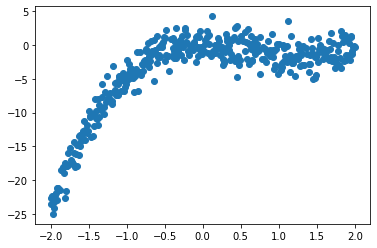

In [39]:
plt.scatter(X_train, y_train)

In [73]:
batch_size = 50

In [74]:
trainloader = Helper.create_loader(X_train, y_train, batch_size)
valiloader = Helper.create_loader(X_vali, y_vali, batch_size)

In [75]:
xvalues = X_train[:50,:]
funcvalues = y_train[:50]
xvalues = xvalues.unsqueeze(0)
funcvalues = funcvalues[None, :, None]

In [80]:
funcvalues.shape

torch.Size([1, 50, 1])

In [76]:
sample_specs_kwargs = {
            "min_trgts": default_conf['single_function']['experiment_params']['min_funcs'],
            "max_trgts": default_conf['single_function']['experiment_params']['max_funcs'],
            "max_contx": default_conf['single_function']['experiment_params']['max_contx'],
            "min_contx": default_conf['single_function']['experiment_params']['min_contx']}



In [77]:
func_idx, contxt_idx = get_sample_indexes(
    **sample_specs_kwargs,
    dim_observation=default_conf['single_function']['experiment_params']['dim_observation']
)

In [81]:
batch_size_small = xvalues.shape[0]
num_contxt, num_trgt, context_x, context_y, target_x, target_y, \
        context_x_stacked, context_y_stacked, target_x_stacked = select_data(
            contxt_idx, func_idx, xvalues,
            funcvalues, batch_size_small)

In [28]:
encoder = Encoder(dimx=1, dimy=1, dimr=128, num_layers=3, num_neurons=128)

In [82]:
encoding = encoder(context_x_stacked, context_y_stacked)

In [88]:
model = LinearRegression()
model.fit(encoding)

TypeError: fit() missing 1 required positional argument: 'y'

In [89]:
target_y.shape

torch.Size([1, 11, 1])